# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs and https://github.com/jayroxis/PINNs.git

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

### 1D EIT problem
$\begin{equation}
\frac{d}{dx} (\sigma(x) \frac{du}{dx}) = 0,
\end{equation}$
where $\sigma(x) = e^{2x}$, and $x\in [0,1]$. The boundary conditions $u(0) = 0$ and $u(1) = 0$. 

In [28]:
import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')

font = {'family': 'helvetica', 'size' :20}
plt.rc('font', **font)

np.random.seed(1234)

In [29]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [30]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [31]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, t, u, layers):
        
        # data
        self.t = torch.tensor(t, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-6, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, t):  
        u = self.dnn(t)
        return u
    
    def net_f(self, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1
        
        u = self.net_u(t)
        sigma = torch.exp(lambda_1*t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_t_sigma = torch.autograd.grad(
            u_t*sigma, t, 
            grad_outputs=torch.ones_like(u_t),
            retain_graph=True,
            create_graph=True
        )[0]
                
        f = u_t_sigma
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.t)
        f_pred = self.net_f(self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)

        return loss
    
    def train(self, nIter):
        It = []
        Loss = []
        Lambda_1 = []
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.t)
            f_pred = self.net_f(self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item()
                    )
                )
                It.append(epoch)
                Loss.append(loss.item())
                Lambda_1.append(self.lambda_1.item())
                
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
        return (It, Loss, Lambda_1)
    
    def predict(self, t):
        t = torch.tensor(t, requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(t)
        f = self.net_f(t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Training on Non-noisy Data

In [32]:
t_b = np.array([0.0, 1.0])
u_b = np.array([0.0, 1.0])

t = np.linspace(0,1,100)

N_u = 50
a = 2
c1 = 1/(1-np.exp(-a))
c2 = -c1
exat_u = c1 + c2 * np.exp(-a*t)

idx = np.random.choice(t.shape[0], N_u, replace=False)
t_f = t[idx]
u_f = exat_u[idx]

t_data = np.concatenate([t_b,t_f]).reshape(52,1)
u_data = np.concatenate([u_b,u_f]).reshape(52,1)

It: 0, Loss: 2.258e-01, Lambda_1: -0.001
It: 100, Loss: 4.391e-02, Lambda_1: 0.050
It: 200, Loss: 1.920e-02, Lambda_1: 0.115
It: 300, Loss: 8.788e-03, Lambda_1: 0.148
It: 400, Loss: 5.290e-03, Lambda_1: 0.174
It: 500, Loss: 4.519e-03, Lambda_1: 0.197
It: 600, Loss: 4.354e-03, Lambda_1: 0.218
It: 700, Loss: 4.278e-03, Lambda_1: 0.235
It: 800, Loss: 4.219e-03, Lambda_1: 0.250
It: 900, Loss: 4.164e-03, Lambda_1: 0.264
It: 1000, Loss: 4.107e-03, Lambda_1: 0.277
It: 1100, Loss: 4.049e-03, Lambda_1: 0.291
It: 1200, Loss: 3.986e-03, Lambda_1: 0.304
It: 1300, Loss: 3.920e-03, Lambda_1: 0.318
It: 1400, Loss: 3.848e-03, Lambda_1: 0.333
It: 1500, Loss: 3.770e-03, Lambda_1: 0.349
It: 1600, Loss: 3.685e-03, Lambda_1: 0.366
It: 1700, Loss: 3.595e-03, Lambda_1: 0.385
It: 1800, Loss: 3.498e-03, Lambda_1: 0.405
It: 1900, Loss: 3.397e-03, Lambda_1: 0.427
It: 2000, Loss: 3.292e-03, Lambda_1: 0.451
It: 2100, Loss: 3.183e-03, Lambda_1: 0.477
It: 2200, Loss: 3.072e-03, Lambda_1: 0.504
It: 2300, Loss: 2.956e

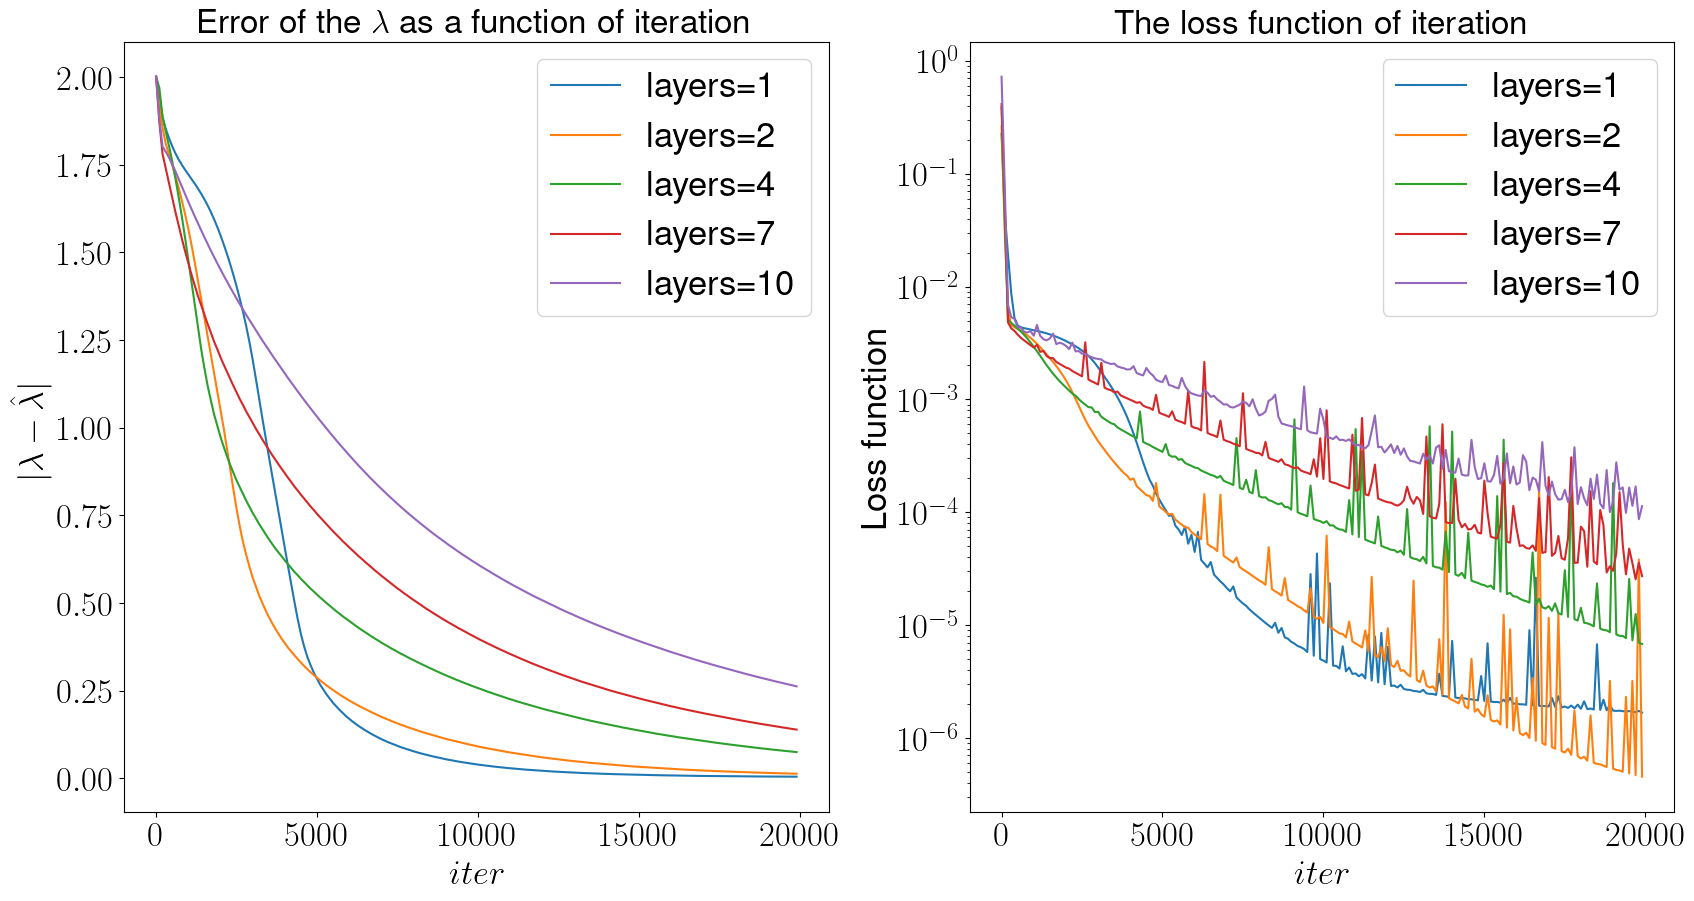

In [33]:
a = [1,2,4,7,10]
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1,2)

plot1 = plt.subplot(gs[0,0])
plot2 = plt.subplot(gs[0,1])

for i in range(len(a)):
    V1 = np.array([1])
    V2 = np.array([20]*a[i])
    V3 = np.array([1])
    layers = np.hstack([V1, V2, V3])
    model = PhysicsInformedNN(t_data, u_data, layers)
    It, Loss, Lambda_1 = model.train(20000)
    plot1.plot(It,np.abs(np.array(Lambda_1)-2),label = 'layers=%d'%a[i])  
    plot2.semilogy(It, Loss,label = 'layers=%d'%a[i]) 

plot1.set_xlabel('$iter$',fontsize=25)
plot1.set_ylabel('$|\lambda - \hat{\lambda}|$',fontsize=25)
plot1.set_title('Error of the $\lambda$ as a function of iteration')
plot1.legend(fontsize=25)
plot1.tick_params(labelsize=25)

plot2.set_xlabel('$iter$',fontsize=25)
plot2.set_ylabel('Loss function',fontsize=25)
plot2.set_title('The loss function of iteration')
plot2.legend(fontsize=25)
plot2.tick_params(labelsize=25)

plt.savefig("EIT_lambda.pdf", format="pdf")

plt.show()

In [38]:
layers = [1, 20, 1]

model = PhysicsInformedNN(t_data, u_data, layers)
model.train(40000)

It: 0, Loss: 6.755e-01, Lambda_1: 0.001
It: 100, Loss: 8.993e-02, Lambda_1: -0.044
It: 200, Loss: 5.442e-02, Lambda_1: 0.040
It: 300, Loss: 3.184e-02, Lambda_1: 0.147
It: 400, Loss: 2.231e-02, Lambda_1: 0.143
It: 500, Loss: 1.654e-02, Lambda_1: 0.141
It: 600, Loss: 1.250e-02, Lambda_1: 0.150
It: 700, Loss: 9.425e-03, Lambda_1: 0.165
It: 800, Loss: 7.076e-03, Lambda_1: 0.183
It: 900, Loss: 5.482e-03, Lambda_1: 0.202
It: 1000, Loss: 4.643e-03, Lambda_1: 0.220
It: 1100, Loss: 4.316e-03, Lambda_1: 0.234
It: 1200, Loss: 4.205e-03, Lambda_1: 0.247
It: 1300, Loss: 4.155e-03, Lambda_1: 0.258
It: 1400, Loss: 4.118e-03, Lambda_1: 0.268
It: 1500, Loss: 4.082e-03, Lambda_1: 0.278
It: 1600, Loss: 4.046e-03, Lambda_1: 0.288
It: 1700, Loss: 4.009e-03, Lambda_1: 0.298
It: 1800, Loss: 3.968e-03, Lambda_1: 0.307
It: 1900, Loss: 3.925e-03, Lambda_1: 0.318
It: 2000, Loss: 3.877e-03, Lambda_1: 0.328
It: 2100, Loss: 3.824e-03, Lambda_1: 0.340
It: 2200, Loss: 3.766e-03, Lambda_1: 0.353
It: 2300, Loss: 3.701e

([0,
  100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000,
  7100,
  7200,
  7300,
  7400,
  7500,
  7600,
  7700,
  7800,
  7900,
  8000,
  8100,
  8200,
  8300,
  8400,
  8500,
  8600,
  8700,
  8800,
  8900,
  9000,
  9100,
  9200,
  9300,
  9400,
  9500,
  9600,
  9700,
  9800,
  9900,
  10000,
  10100,
  10200,
  10300,
  10400,
  10500,
  10600,
  10700,
  10800,
  10900,
  11000,
  11100,
  11200,
  11300,
  11400,
  11500,
  11600,
  11700,
  11800,
  11900,
  12000,
  12100,
  12200,
  123

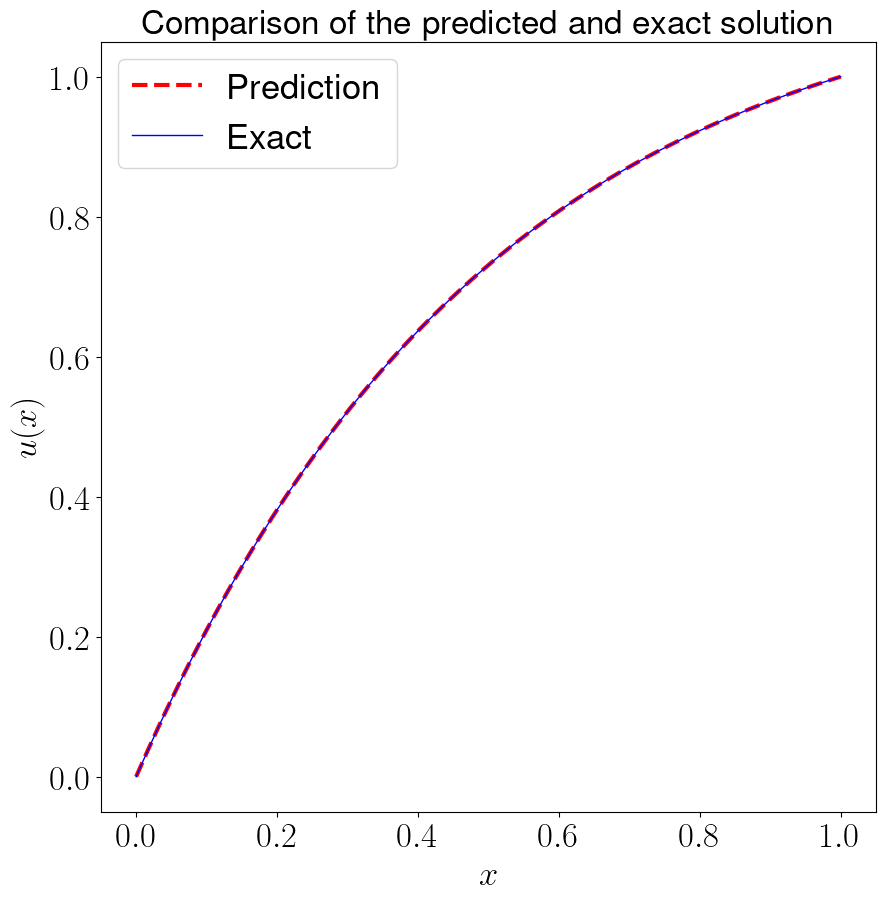

In [39]:
t = t.reshape(100,1)
u_pred, f_pred = model.predict(t) 

fig,ax = plt.subplots(figsize=(10, 10))
ax.plot(t,u_pred,'r--',linewidth = 3, label='Prediction')
ax.plot(t,exat_u,'b-', linewidth = 1, label = 'Exact')
ax.set_xlabel('$x$', fontsize=25)
ax.set_ylabel('$u(x)$', fontsize=25)
ax.set_title('Comparison of the predicted and exact solution')
ax.legend(fontsize=25)
ax.tick_params(labelsize=25)
plt.savefig("EIT_prediction.pdf", format="pdf")
plt.show()

In [40]:
lambda_1_value = model.lambda_1.detach().cpu().numpy()
error_lambda_1 = np.abs(lambda_1_value - 2.0)/2.0*100
print('Error l1: %.5f%%' % (error_lambda_1))  

Error l1: 0.07209%


## Training on Noisy Data

In [41]:
noise = 0.01    

# create training set
u_train_noise = u_data + noise*np.std(u_data)*np.random.randn(u_data.shape[0], u_data.shape[1])

model = PhysicsInformedNN(t_data, u_train_noise, layers)
model.train(40000)

It: 0, Loss: 3.987e-01, Lambda_1: -0.001
It: 100, Loss: 6.535e-02, Lambda_1: 0.073
It: 200, Loss: 2.736e-02, Lambda_1: 0.193
It: 300, Loss: 1.534e-02, Lambda_1: 0.206
It: 400, Loss: 9.605e-03, Lambda_1: 0.207
It: 500, Loss: 6.568e-03, Lambda_1: 0.216
It: 600, Loss: 5.079e-03, Lambda_1: 0.230
It: 700, Loss: 4.429e-03, Lambda_1: 0.245
It: 800, Loss: 4.167e-03, Lambda_1: 0.260
It: 900, Loss: 4.049e-03, Lambda_1: 0.275
It: 1000, Loss: 3.978e-03, Lambda_1: 0.289
It: 1100, Loss: 3.925e-03, Lambda_1: 0.303
It: 1200, Loss: 3.878e-03, Lambda_1: 0.316
It: 1300, Loss: 3.834e-03, Lambda_1: 0.328
It: 1400, Loss: 3.790e-03, Lambda_1: 0.340
It: 1500, Loss: 3.744e-03, Lambda_1: 0.352
It: 1600, Loss: 3.695e-03, Lambda_1: 0.364
It: 1700, Loss: 3.642e-03, Lambda_1: 0.376
It: 1800, Loss: 3.586e-03, Lambda_1: 0.389
It: 1900, Loss: 3.526e-03, Lambda_1: 0.402
It: 2000, Loss: 3.462e-03, Lambda_1: 0.416
It: 2100, Loss: 3.396e-03, Lambda_1: 0.431
It: 2200, Loss: 3.327e-03, Lambda_1: 0.446
It: 2300, Loss: 3.256e

([0,
  100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000,
  7100,
  7200,
  7300,
  7400,
  7500,
  7600,
  7700,
  7800,
  7900,
  8000,
  8100,
  8200,
  8300,
  8400,
  8500,
  8600,
  8700,
  8800,
  8900,
  9000,
  9100,
  9200,
  9300,
  9400,
  9500,
  9600,
  9700,
  9800,
  9900,
  10000,
  10100,
  10200,
  10300,
  10400,
  10500,
  10600,
  10700,
  10800,
  10900,
  11000,
  11100,
  11200,
  11300,
  11400,
  11500,
  11600,
  11700,
  11800,
  11900,
  12000,
  12100,
  12200,
  123

In [42]:
lambda_1_value_noise = model.lambda_1.detach().cpu().numpy()
error_lambda_1_noise = np.abs(lambda_1_value_noise - 2.0)/2.0*100
print('Error l1: %.5f%%' % (error_lambda_1_noise))

Error l1: 0.02946%


### Identified ODE

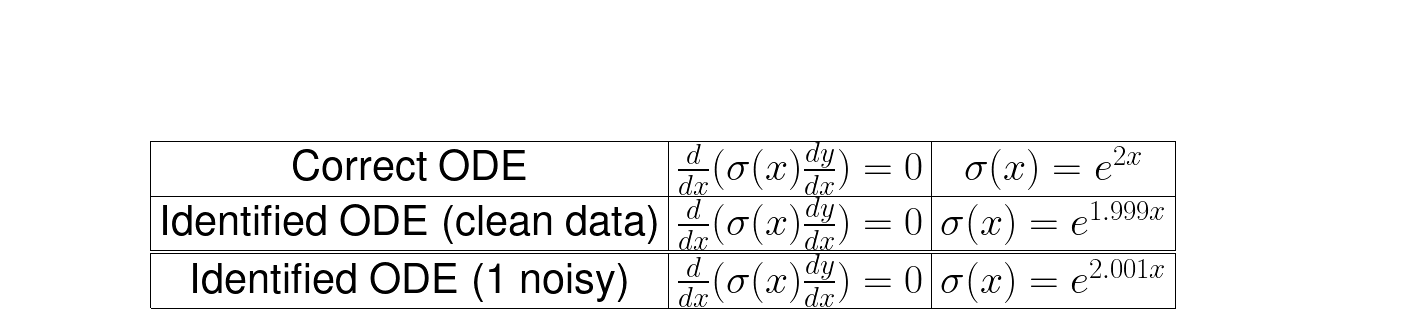

In [43]:
####### Row 3: Identified PDE ##################    


fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

s1 = r'$\begin{tabular}{ |c|c|c| }  \hline Correct ODE & $\frac{d}{dx} (\sigma(x) \frac{dy}{dx}) = 0$ & $\sigma(x) = e^{2x}$\\'
s2 = r'\hline Identified ODE (clean data) & $\frac{d}{dx} (\sigma(x) \frac{dy}{dx}) = 0$ & $\sigma(x) = e^{%.3fx}$ \\  \hline ' % (lambda_1_value)
s3 = r'\hline Identified ODE (1 noisy) & $\frac{d}{dx} (\sigma(x) \frac{dy}{dx}) = 0$ & $\sigma(x) = e^{%.3fx}$ \\  \hline ' % (lambda_1_value_noise)
s4 = r'\end{tabular}$'
s = s1+s2+s3+s4
ax.text(0.1, 0.1, s, size=30)

plt.show()